# Testing Integrators on Double Pendulums

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Acceleration Function

In [2]:
def acceleration(theta1, omega1, theta2, omega2):
    term1 = g * (2*m1 + m2) * np.sin(theta1)
    term2 = m2*g*np.sin(theta1 - 2*theta2)
    term3 = 2*np.sin(theta1 - theta2) * m2 * (omega2**2 * l2 + omega1**2 * l1 * np.cos(theta1 - theta2))
    denominator1 = l1 * (2*m1 + m2 - m2 * np.cos(2*theta1 - 2*theta2))
    acc1 = (- term1 - term2 - term3) / denominator1
    
    term4 = 2 * np.sin(theta1 - theta2)
    term5 = (omega1**2 * l1 * (m1 + m2))
    term6 = g * (m1 + m2) * np.cos(theta1)
    term7 = omega2**2 * l2 * m2 * np.cos(theta1 - theta2)
    denominator2 = l2 * (2 * m1 + m2 - m2 * np.cos(2 * theta1 - 2 * theta2))
    acc2 = (term4 * (term5 + term6 + term7)) / denominator2
    
    return acc1, acc2
    

## Integrators

In [3]:
def euler(theta1, omega1, theta2, omega2, h, t):
    acc = acceleration(theta1, omega1, theta2, omega2)
    return omega1, acc[0], omega2, acc[1]

In [4]:
def rk4(theta1, omega1, theta2, omega2, h, t):
    k1 = euler(theta1, omega1, theta2, omega2, h, t)
    k2 = euler(theta1 + 0.5*h*k1[0], omega1 + 0.5*h*k1[1], theta2 + 0.5*h*k1[2], omega2 + 0.5*h*k1[3], h, t + 0.5*h)
    k3 = euler(theta1 + 0.5*h*k2[0], omega1 + 0.5*h*k2[1], theta2 + 0.5*h*k2[2], omega2 + 0.5*h*k2[3], h, t + 0.5*h)
    k4 = euler(theta1 + h*k3[0], omega1 + h*k3[1], theta2 + h*k3[2], omega2 + h*k3[3], h, t + h)
    theta1 = (1 / 6) * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
    omega1 = (1 / 6) * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
    theta2 = (1 / 6) * (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
    omega2 = (1 / 6) * (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])
    
    return theta1, omega1, theta2, omega2, t + h

## Simulation

In [5]:
def integrate(theta1, omega1, theta2, omega2, h, t0, t1, integrator):
    twoPi = 2 * np.pi
    
    t = t0
    theta1s = list()
    omega1s = list()
    theta2s = list()
    omega2s = list()
    ts = list()
    
    theta1s.append(theta1)
    omega1s.append(omega1)
    theta2s.append(theta2)
    omega2s.append(omega2)
    ts.append(t)
    while t < t1:
        state = integrator(theta1, omega1, theta2, omega2, h, t)
        theta1 = theta1 + state[0] * h
        omega1 = omega1 + state[1] * h
        theta2 = theta2 + state[2] * h
        omega2 = omega2 + state[3] * h
        t = t + h
        
        if theta1 > twoPi:
            theta1 = theta1 - twoPi
        elif theta1 < -twoPi:
            theta1 = theta1 + twoPi
        
        if theta2 > twoPi:
            theta2 = theta2 - twoPi
        elif theta2 < -twoPi:
            theta2 = theta2 + twoPi
        
        theta1s.append(theta1)
        omega1s.append(omega1)
        theta2s.append(theta2)
        omega2s.append(omega2)
        ts.append(t)
    
    states = {
        "theta1s": np.array(theta1s),
        "omega1s": np.array(omega1s),
        "theta2s": np.array(theta2s),
        "omega2s": np.array(omega2s),
        "ts": np.array(ts),
    }
    return states

In [26]:
def energy(states):
    
    x1s = l1 * np.sin(states["theta1s"])
    y1s = - l1 * np.cos(states["theta1s"])
    x2s = l2 * np.sin(states["theta2s"]) + x1s
    y2s = - l2 * np.cos(states["theta2s"]) + y1s
    
#     vx1s = l1 * states["omega1s"] * np.cos(states["theta1s"])
#     vy1s = l1 * states["omega1s"] * np.sin(states["theta1s"])
#     vx2s = l2 * states["omega2s"] * np.cos(states["theta2s"]) + vx1s
#     vy2s = l2 * states["omega2s"] * np.sin(states["theta2s"]) + vy1s

    # potentials = m1 * g * y1s + m2 * g * y2s
    pendulumBase = l1 + l2
    potentials = m1 * g * (pendulumBase + y1s) + m2 * g * (pendulumBase + y2s)
    
    kinetics = 0.5 * m1 * l1**2 * states["omega1s"]**2 + 0.5 * m2 * (l2**2 * states["omega2s"]**2 + 2 * l1 * l2 * states["omega1s"] * states["omega2s"] * np.cos(states["theta1s"] - states["theta2s"]) + l1**2 * states["omega1s"]**2)
    
    energies = {
        "potentials": potentials,
        "kinetics": kinetics,
        "totals": potentials + kinetics,
    }
    
    return energies

In [56]:
def errors(energies):
    minTotalEnergyError = (energies["totals"] - energies["totals"][0]).min()
    maxTotalEnergyError = (energies["totals"] - energies["totals"][0]).max()

    if minTotalEnergyError < -maxTotalEnergyError:
        maximumMagnitudeError = minTotalEnergyError
    else:
        maximumMagnitudeError = maxTotalEnergyError
        

    print(f'Total energy at t = 0: {energies["totals"][0]} joules')
    print(f'Maximum total energy error: {maximumMagnitudeError} joules')
    print(f'Standard deviation in total energy: {energies["totals"].std()} joules')
    print(f'Mean total energy: {energies["totals"].mean()} joules')

In [49]:
m1 = 10
m2 = 10
g = 9.81
l1 = 100
l2 = 100
theta1 = 1 * np.pi + 1e-5
theta2 = 1 * np.pi
omega1 = 0
omega2 = 0
h = 0.01
t = 0

## Plotting Functions

In [9]:
def plotEnergies(states, energies):
    plt.figure(figsize=(10, 8))
    plt.plot(states["ts"], energies["potentials"], label="Potenital")
    plt.plot(states["ts"], energies["kinetics"], label="Kinetic")
    plt.plot(states["ts"], energies["potentials"] + energies["kinetics"], label="Total")
    plt.title("Energy over Time")
    plt.legend()
    plt.grid()

In [10]:
def plotError(states, energies):
    plt.figure(figsize=(10, 8))
    plt.plot(states["ts"], energies["totals"] - energies["totals"][0], label="Error")
    plt.title("Error in Total Energy over Time")
    plt.legend()
    plt.grid()

## Testing Euler

In [59]:
states = integrate(theta1, omega1, theta2, omega2, h, t, 1000, euler)
energies = energy(states)

In [60]:
errors(energies)

Total energy at t = 0: 68669.99999901901 joules
Maximum total energy error: 19495.28012383687 joules
Standard deviation in total energy: 5691.61937028014 joules
Mean total energy: 78802.35061384179 joules


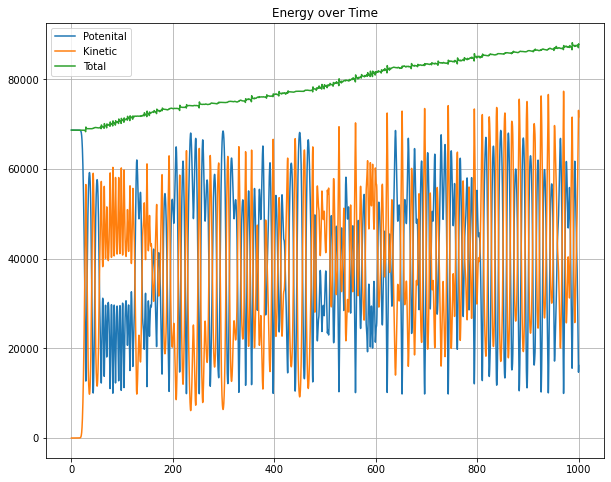

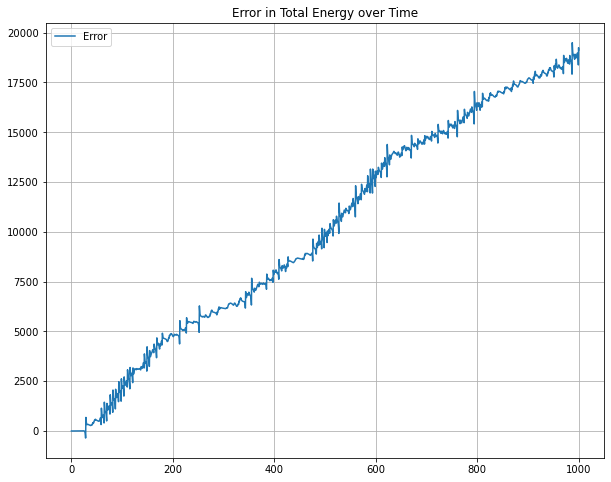

In [61]:
plotEnergies(states, energies)
plotError(states, energies)

## Testing RK4

In [62]:
states = integrate(theta1, omega1, theta2, omega2, h, t, 1000, rk4)
energies = energy(states)

In [63]:
errors(energies)

Total energy at t = 0: 68669.99999901901 joules
Maximum total energy error: -0.000623989209998399 joules
Standard deviation in total energy: 0.00015797475268509753 joules
Mean total energy: 68669.99979267875 joules


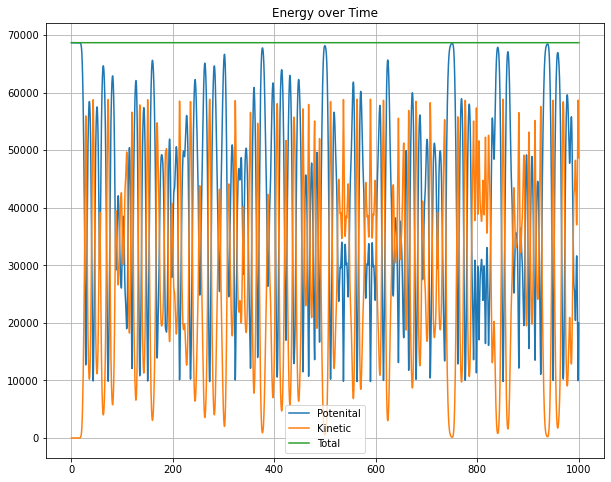

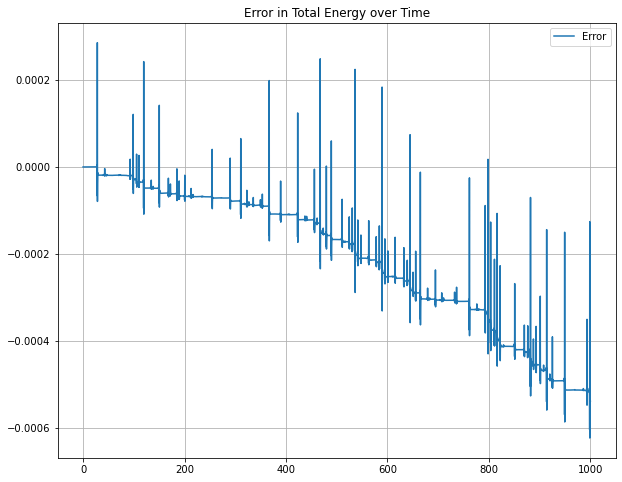

In [64]:
plotEnergies(states, energies)
plotError(states, energies)